<a href="https://colab.research.google.com/github/hyeonseonn/sensing_app/blob/main/0721_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. CNN_LSTM + sliding window (5)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

#1. data
np.random.seed(42) # 매번 돌릴때마다 같은 결과 나오도록 seed
days = 30 # 5분 단위 한 달 데이터
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')

# CPU 패턴 (주기적인 패턴 + 노이즈 + 증가 추세)
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

# 2. 정규화
scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# 3. sequence 생성 (시계열 -> 예측)
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5
X, y = create_sequences(scaled_cpu, past_steps, future_steps)

# 8:2 학습
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"입력 X_train shape: {X_train.shape}, 출력 y_train shape: {y_train.shape}")

# 5. CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(future_steps))  # future step에서의 CPU 예측
model.compile(optimizer='adam', loss='mse')


model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), # -1: numpy가 알아서 차원 계산하도록
          epochs=50, batch_size=16, verbose=1)


# 6. prediction
pred = model.predict(X_test)
pred = pred.reshape(-1, future_steps)  # future_step (5) step 예측
y_true = y_test.reshape(-1, future_steps)



/tmp/ipython-input-5-3466844006.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


입력 X_train shape: (6892, 20, 1), 출력 y_train shape: (6892, 5, 1)
Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0399
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2190e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2330e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1573e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0857e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.0538e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.8376e-04
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7254e-04
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.5885e-04
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6810e-04
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6478e-04
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5290e-04
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5155e-04
Epoch 14/50
4

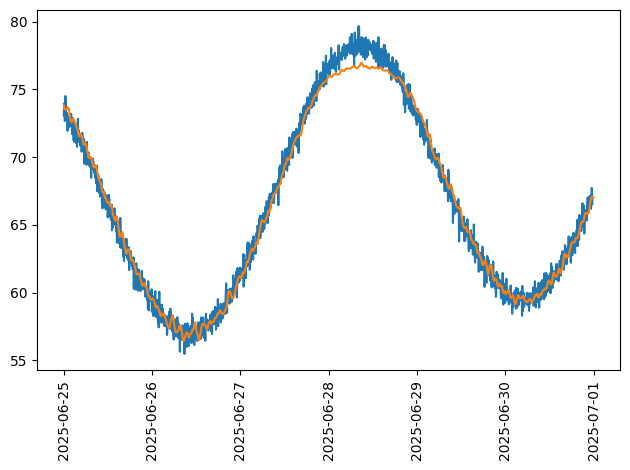

In [33]:
future_steps = 5
future_interval = 5  # 5분 단위

# 테스트셋 시작 index
test_start_idx = train_size + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

all_future_times = []
all_future_preds = []

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

# 동일 시간에서의 예측값 평균 (sliding window라서 겹치는 부분 발생)
pred_df_mean = pred_df.groupby("time").mean().sort_index()

# # df[['cpu']] → scaler.inverse_transform 하면 shape=(N,1)
# # df_inv = scaler.inverse_transform(df[['cpu']].values)

# # 1D로 변환 후 Series 생성
# df_inv_series = df[['cpu']].values

y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)

shifted_true_times = [t + pd.Timedelta(minutes=5) for t in test_time_index]
plt.plot(shifted_true_times, y_true_inv[:,0], label="Shifted True (5min ahead)")
plt.plot(pred_df_mean.index, pred_df_mean['pred'], label="Pred")

# label_x 세로
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


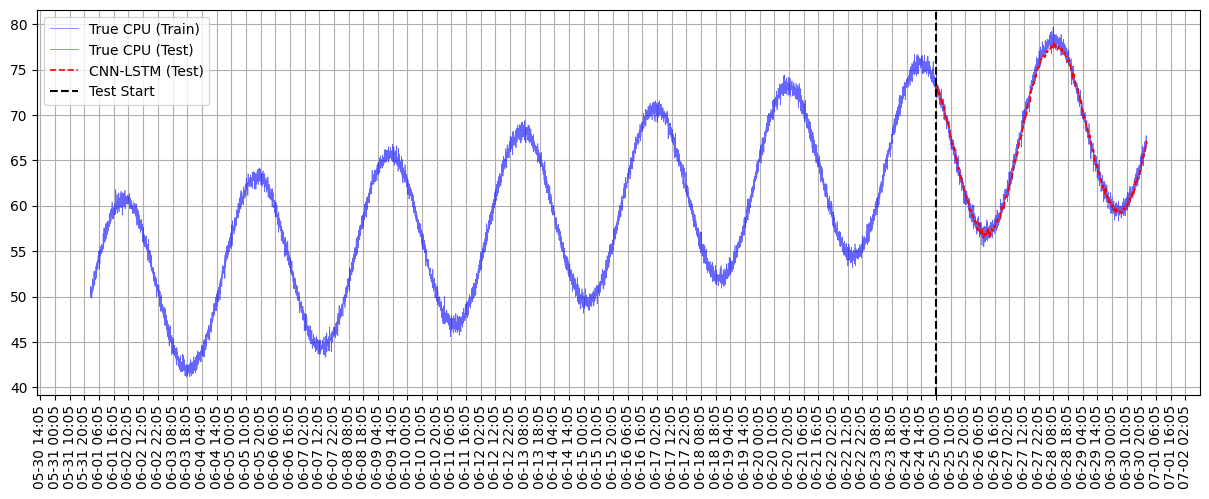

In [15]:
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(y_true_inv[:,0].flatten(), index=test_time_index) # test data (True)

test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(15,5))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600)) # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.show()


Result for Moving Average
MAE : 0.5517
RMSE: 0.6882

Result for CNN-LSTM
MAE : 0.5051
RMSE: 0.6320


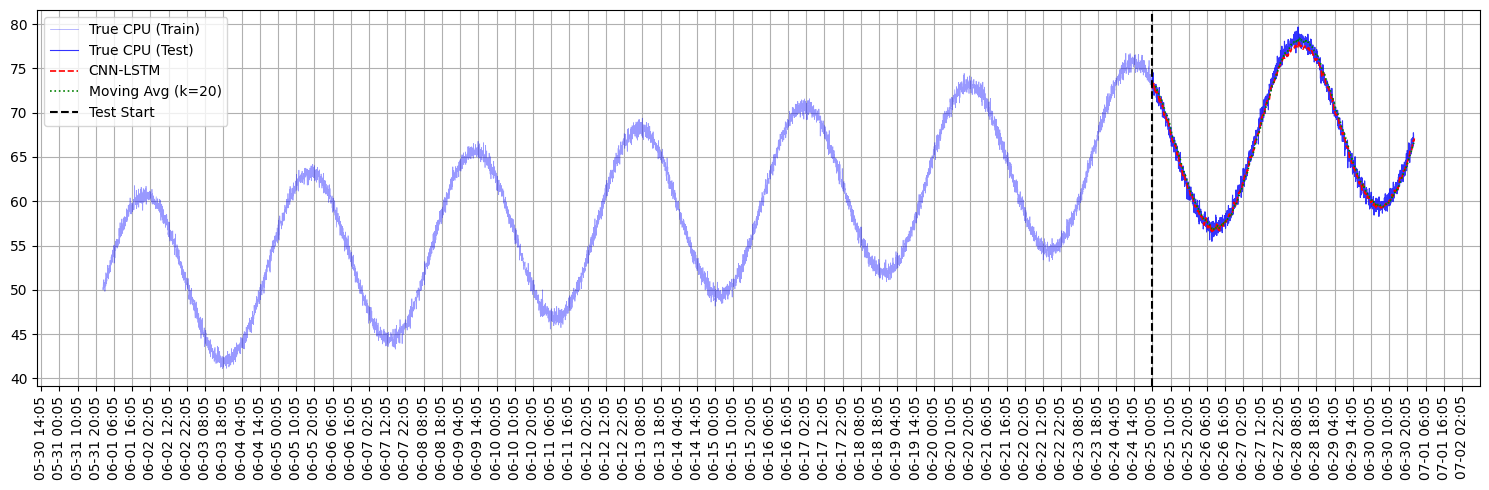

In [22]:
# 정확도 분석

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Moving Average 방식
k = 20  # 최근 20 step 평균 (원하는 값으로 조절)
moving_avg_pred = []

for i in range(k, len(test_series_true)):
    moving_avg_pred.append(np.mean(test_series_true[i-k:i]))  # k개 평균

moving_avg_pred_series = pd.Series(moving_avg_pred, index=test_time_index[k:])  # k step 이후부터 가능


true_vals = test_series_true.values
cnn_pred_vals = test_series_pred.values[:len(true_vals)]  # 길이 맞춤

mae_cnn = mean_absolute_error(true_vals, cnn_pred_vals)
rmse_cnn = np.sqrt(mean_squared_error(true_vals, cnn_pred_vals))
r2_cnn = r2_score(true_vals, cnn_pred_vals)

true_vals_ma = true_vals[k:]  # k step 이후부터만 비교 가능
mae_ma = mean_absolute_error(true_vals_ma, moving_avg_pred)
rmse_ma = np.sqrt(mean_squared_error(true_vals_ma, moving_avg_pred))
r2_ma = r2_score(true_vals_ma, moving_avg_pred)

print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}")
print(f"RMSE: {rmse_ma:.4f}")
# print(f"R²  : {r2_ma:.4f}")

print("\nResult for CNN-LSTM")
print(f"MAE : {mae_cnn:.4f}")
print(f"RMSE: {rmse_cnn:.4f}")
# print(f"R²  : {r2_cnn:.4f}")

fig, ax = plt.subplots(figsize=(15,5))

plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.4, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.8, linewidth=0.8)
plt.plot(test_series_pred, label="CNN-LSTM", color="red", linestyle="--", linewidth=1.2)
plt.plot(moving_avg_pred_series, label=f"Moving Avg (k={k})", color="green", linestyle=":", linewidth=1.2)

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")  # test 시작선

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))  # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2. CNN-BiLSTM + sliding window (5) + CNN 2층 쌓기

입력 X_train shape: (6892, 20, 1), 출력 y_train shape: (6892, 5, 1)


/tmp/ipython-input-26-609321960.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 18, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 7, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 3, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,477 (662.02 KB)

 Trainable params: 169,477 (662.02 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0239
Epoch 2/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 6.8680e-04
Epoch 3/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 6.0580e-04
Epoch 4/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 5.5853e-04
Epoch 5/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 5.0162e-04
Epoch 6/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 5.0751e-04
Epoch 7/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.7146e-04
Epoch 8/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.6038e-04
Epoch 9/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 4.4876e-04
Epoch 10/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.7057e-04
Epoch 11/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 4.1959e-04
Epoch 12/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 4.0137e-04
Epoch 13/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.9222e-04
Epoch 14/50
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - lo

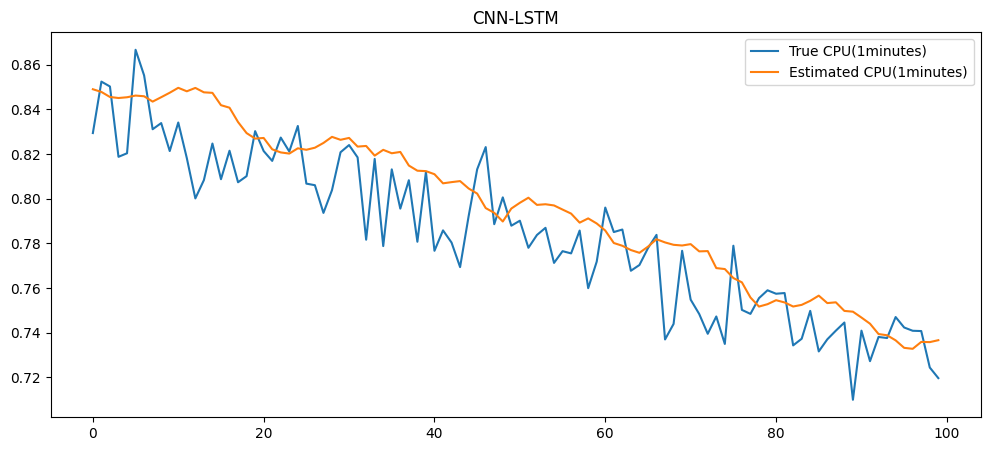

In [26]:
#1. data
# datapoint 갯수 많으므로 sliding window 방식
np.random.seed(42)
days = 30 # 5분 단위 한 달 데이터
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미

cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5
X, y = create_sequences(scaled_cpu, past_steps, future_steps)

train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"입력 X_train shape: {X_train.shape}, 출력 y_train shape: {y_train.shape}")

# 5. CNN-LSTM
# CNN을 더쌓아
from tensorflow.keras.layers import Bidirectional, Dropout

model = Sequential()

# CNN 두 층
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))  # 추가 CNN
model.add(MaxPooling1D(pool_size=2))

# Bidirectional LSTM --> 양방향 패턴 학습
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # 첫번째 BiLSTM
model.add(Dropout(0.2))  # 과적합 방지
model.add(Bidirectional(LSTM(32)))  # 두번째 BiLSTM

model.add(Dense(64, activation='relu'))  # 추가 Dense
model.add(Dense(future_steps))  # 미래 step 예측

model.compile(optimizer='adam', loss='mse')

print(model.summary())

model.fit(X_train, y_train.reshape((y_train.shape[0], -1)), # -1: numpy가 알아서 차원 계산하도록
          epochs=50, batch_size=16, verbose=1)


# 6. prediction
pred = model.predict(X_test)
pred = pred.reshape(-1, future_steps)  # 미래 5분 예측
y_true = y_test.reshape(-1, future_steps)



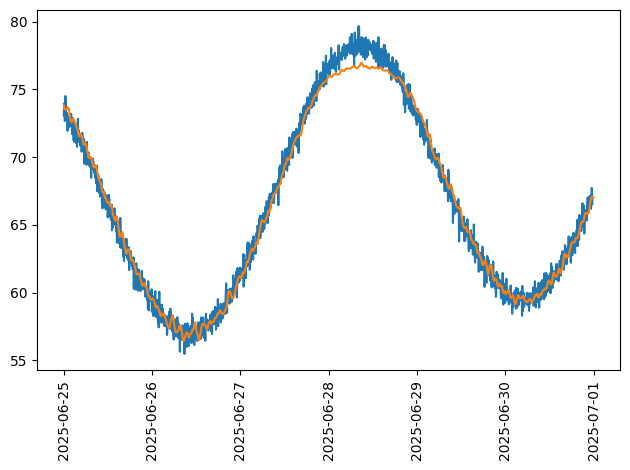

In [32]:
future_steps = 5
future_interval = 5  # 5분 단위

# 테스트셋 시작 index
test_start_idx = train_size + past_steps
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

all_future_times = []
all_future_preds = []

# timestamp 매핑
for i in range(len(test_time_index)):
    for j in range(future_steps):
        # 샘플 끝나는 시점 + (j+1)*5분
        future_time = test_time_index[i] + pd.Timedelta(minutes=(j+1)*future_interval)
        all_future_times.append(future_time)
        all_future_preds.append(pred[i, j])

pred_df = pd.DataFrame({"time": all_future_times,
                        "pred": scaler.inverse_transform(np.array(all_future_preds).reshape(-1,1)).flatten()})

# 동일 시간에서의 예측값 평균 (sliding window라서 겹치는 부분 발생)
pred_df_mean = pred_df.groupby("time").mean().sort_index()

# # df[['cpu']] → scaler.inverse_transform 하면 shape=(N,1)
# # df_inv = scaler.inverse_transform(df[['cpu']].values)

# # 1D로 변환 후 Series 생성
# df_inv_series = df[['cpu']].values

y_true_inv = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)
shifted_true_times = [t + pd.Timedelta(minutes=5) for t in test_time_index]
plt.plot(shifted_true_times, y_true_inv[:,0], label="Shifted True (5min ahead)")
plt.plot(pred_df_mean.index, pred_df_mean['pred'], label="Pred")

# label_x 세로
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

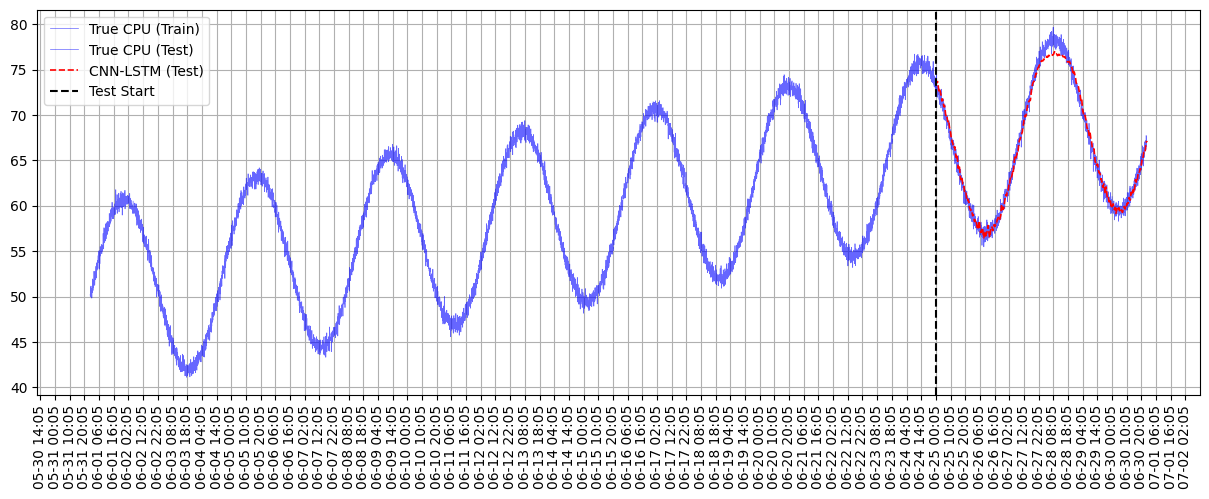

In [28]:
import matplotlib.dates as mdates
full_time_index = df.index  # 전체 시간 index (x축)
train_series = df['cpu'][:test_start_idx]  # Test 시작 전까지

test_series_true = pd.Series(y_true_inv[:,0].flatten(), index=test_time_index) # test data (True)

test_series_pred = pd.Series(pred_df_mean['pred'], index=pred_df_mean.index) # test data (estimated)


# visualization
fig, ax = plt.subplots(figsize=(15,5))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")
plt.plot(train_series,label = "True CPU (Train)", color = "blue", alpha = 0.6,linewidth = 0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha = 0.6, linewidth = 0.5)
plt.plot(test_series_pred, label="CNN-LSTM (Test)", color="red", linestyle="--", linewidth = 1.2)
plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start") # test data start line
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600)) # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.show()


Result for Moving Average
MAE : 0.5517
RMSE: 0.6882

Result for CNN-LSTM
MAE : 0.5966
RMSE: 0.7623


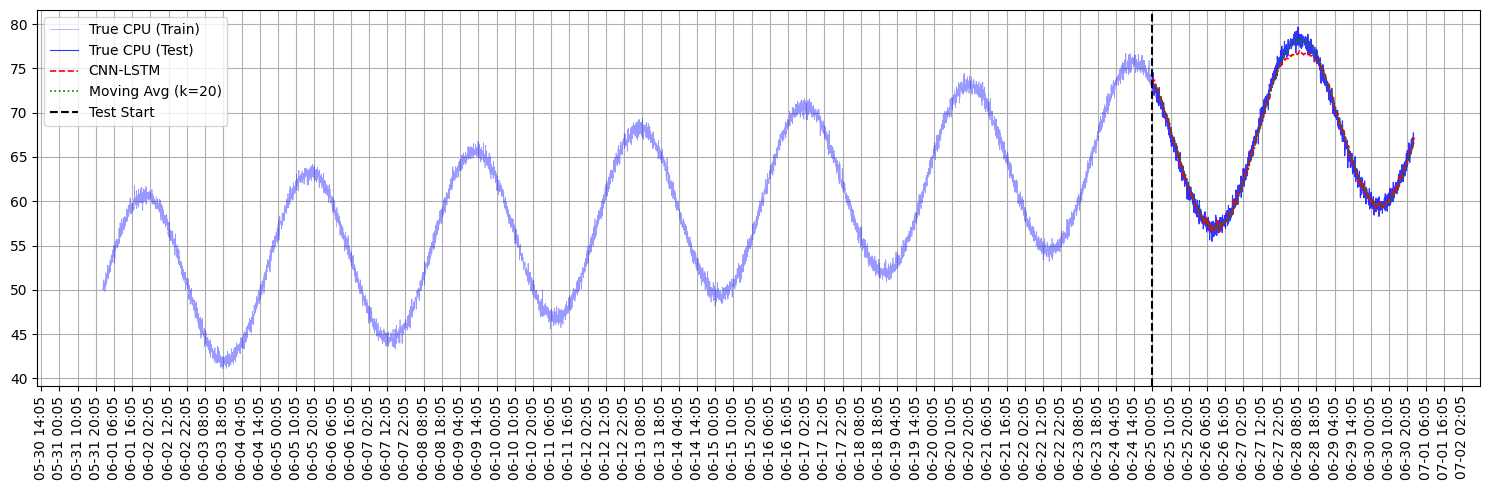

In [29]:
# 정확도 분석

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Moving Average 방식
k = 20  # 최근 20 step 평균 (원하는 값으로 조절)
moving_avg_pred = []

for i in range(k, len(test_series_true)):
    moving_avg_pred.append(np.mean(test_series_true[i-k:i]))  # k개 평균

moving_avg_pred_series = pd.Series(moving_avg_pred, index=test_time_index[k:])  # k step 이후부터 가능


true_vals = test_series_true.values
cnn_pred_vals = test_series_pred.values[:len(true_vals)]  # 길이 맞춤

mae_cnn = mean_absolute_error(true_vals, cnn_pred_vals)
rmse_cnn = np.sqrt(mean_squared_error(true_vals, cnn_pred_vals))
r2_cnn = r2_score(true_vals, cnn_pred_vals)

true_vals_ma = true_vals[k:]  # k step 이후부터만 비교 가능
mae_ma = mean_absolute_error(true_vals_ma, moving_avg_pred)
rmse_ma = np.sqrt(mean_squared_error(true_vals_ma, moving_avg_pred))
r2_ma = r2_score(true_vals_ma, moving_avg_pred)

print("Result for Moving Average")
print(f"MAE : {mae_ma:.4f}")
print(f"RMSE: {rmse_ma:.4f}")
# print(f"R²  : {r2_ma:.4f}")

print("\nResult for CNN-LSTM")
print(f"MAE : {mae_cnn:.4f}")
print(f"RMSE: {rmse_cnn:.4f}")
# print(f"R²  : {r2_cnn:.4f}")

fig, ax = plt.subplots(figsize=(15,5))

plt.plot(train_series, label="True CPU (Train)", color="blue", alpha=0.4, linewidth=0.5)
plt.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.8, linewidth=0.8)
plt.plot(test_series_pred, label="CNN-LSTM", color="red", linestyle="--", linewidth=1.2)
plt.plot(moving_avg_pred_series, label=f"Moving Avg (k={k})", color="green", linestyle=":", linewidth=1.2)

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")  # test 시작선

ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))  # 10시간 간격
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # (k, mae, rmse, complexity)

for k in k_list:
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # k step 이후
    true_vals_ma = test_series_true.values[k:]

    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    complexity = len(test_series_true) * k

    results.append((k, mae, rmse, complexity))

results_arr = np.array(results)
k_values = results_arr[:,0]
mae_values = results_arr[:,1]
rmse_values = results_arr[:,2]
complexity_values = results_arr[:,3]

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(k_values, mae_values, marker='o', label="MAE", color='blue')
ax1.plot(k_values, rmse_values, marker='s', label="RMSE", color='red')
ax1.set_xlabel("Moving Average Window k")
ax1.set_ylabel("Error")
ax1.grid(True)
ax1.legend(loc="upper left")

# complexity
ax2 = ax1.twinx()
ax2.plot(k_values, complexity_values, marker='^', label="Complexity (Ops ~ N*k)", color='green', linestyle='--')
ax2.set_ylabel("Complexity")
ax2.legend(loc="upper right")

plt.title("k vs MAE/RMSE & Complexity")
plt.tight_layout()
plt.show()

for k, mae, rmse, comp in results:
    print(f"k={int(k):2d}  MAE={mae:.4f}  RMSE={rmse:.4f}  Complexity≈{int(comp)} ops")


NameError: name 'test_series_true' is not defined

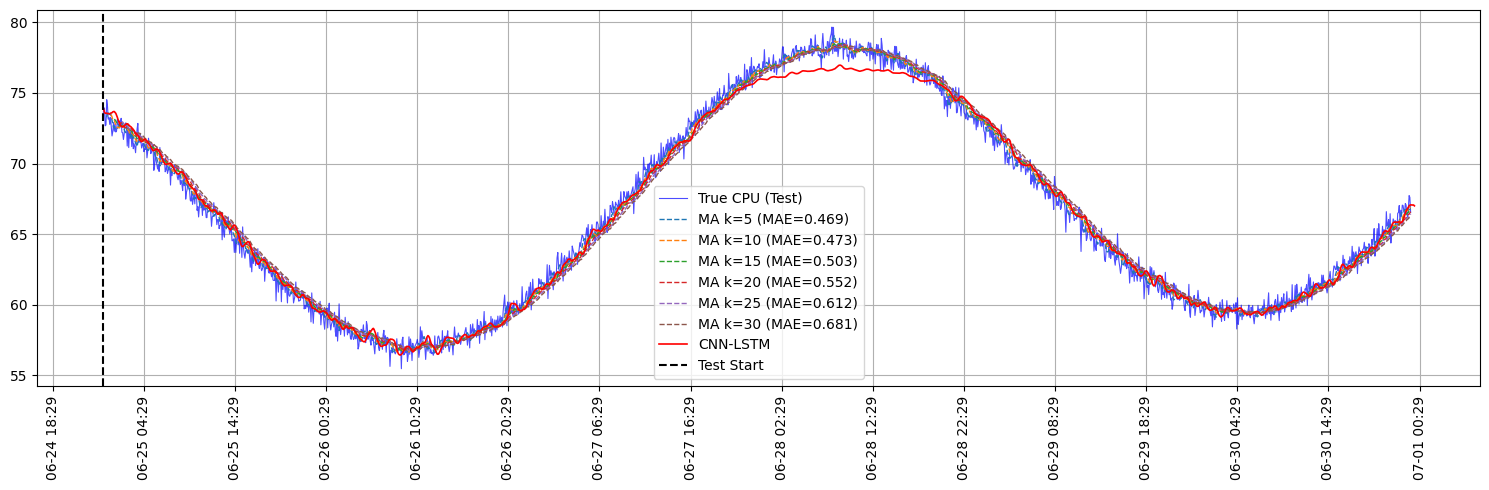

=== Moving Average 성능 비교 ===
k= 5  MAE=0.4693  RMSE=0.5886
k=10  MAE=0.4728  RMSE=0.5958
k=15  MAE=0.5032  RMSE=0.6329
k=20  MAE=0.5517  RMSE=0.6882
k=25  MAE=0.6119  RMSE=0.7564
k=30  MAE=0.6807  RMSE=0.8298


In [39]:
k_list = [5, 10, 15, 20, 25, 30]  # 테스트할 이동평균 윈도우
results = []  # MAE/RMSE 저장 리스트
fig, ax = plt.subplots(figsize=(15,5))

# True 값은 한 번만 그리기
ax.plot(test_series_true, label="True CPU (Test)", color="blue", alpha=0.7, linewidth=0.8)

for k in k_list:
    # Moving Average 계산
    ma_pred = []
    for i in range(k, len(test_series_true)):
        ma_pred.append(np.mean(test_series_true[i-k:i]))

    # Series 생성 (index 맞춤)
    ma_pred_series = pd.Series(ma_pred, index=test_time_index[k:])

    # 성능 측정
    true_vals_ma = test_series_true.values[k:]  # k step 이후만 비교
    mae = mean_absolute_error(true_vals_ma, ma_pred)
    rmse = np.sqrt(mean_squared_error(true_vals_ma, ma_pred))

    # 저장
    results.append((k, mae, rmse))

    # 그래프에 추가
    ax.plot(ma_pred_series, label=f"MA k={k} (MAE={mae:.3f})", linestyle="--", linewidth=1)

# CNN-LSTM도 같이 비교
ax.plot(test_series_pred, label="CNN-LSTM", color="red", linewidth=1.2)

# X축 tick 설정
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=600))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.axvline(test_time_index[0], color="black", linestyle="--", label="Test Start")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# k별 성능 출력
print("=== Moving Average 성능 비교 ===")
for k, mae, rmse in results:
    print(f"k={k:2d}  MAE={mae:.4f}  RMSE={rmse:.4f}")


## 3. LSTM + sliding window (1)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 5분 단위 한 달 데이터 생성
np.random.seed(42)
days = 60
points_per_day = 24 * 12  # 하루 288 포인트 (5분 단위)
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')

# CPU 패턴 (주기적인 패턴 + 노이즈 + 증가 추세)
cpu = 50 + 10*np.sin(np.linspace(0, 50, total_points)) + np.random.normal(0, 0.5, total_points) + np.linspace(0, 20, total_points)
df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# sliding window function, lookback_time만큼을 보고 predict_time만큼 추정
def create_sliding_window_data(data, lookback_time, predict_time):
    X, y = [], []
    for i in range(len(data) - lookback_time - predict_time + 1):
        x_window = data[i:i+lookback_time]
        y_value  = data[i+lookback_time+predict_time-1]
        X.append(x_window)
        y.append(y_value)
    return np.array(X), np.array(y)

lookback = 20  # 과거 20개 step 사용
predict_horizon = 1  # 1 step ahead 예측
X, y = create_sliding_window_data(df['cpu'].values, lookback, predict_horizon)

# LSTM 입력 차원 맞추기: (샘플수, time_steps, feature=1)
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"input shape: {x_train.shape}, output shape: {y_train.shape}")

# LSTM 모델 정의
cell_size = 128
timesteps = lookback
feature = 1

model = Sequential(name="CPU_LSTM")
model.add(LSTM(cell_size, input_shape=(timesteps, feature), return_sequences=True))
model.add(LSTM(cell_size))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(learning_rate=0.0005),
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

model.summary()

history = model.fit(x_train, y_train,
                    epochs=50, batch_size=16,
                    validation_data=(x_test, y_test),
                    verbose=1)

y_pred = model.predict(x_test)

# 스케일 inverse
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

/tmp/ipython-input-5-2723117393.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


input shape: (13808, 20, 1), output shape: (13808, 1)


Model: "CPU_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - loss: 1366.7142 - mean_absolute_error: 33.9769 - root_mean_squared_error: 36.2394 - val_loss: 260.9185 - val_mean_absolute_error: 14.6715 - val_root_mean_squared_error: 16.1530
Epoch 2/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - loss: 89.0149 - mean_absolute_error: 7.6902 - root_mean_squared_error: 9.4206 - val_loss: 114.4880 - val_mean_absolute_error: 8.4470 - val_root_mean_squared_error: 10.6999
Epoch 3/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 70.9086 - mean_absolute_error: 6.9932 - root_mean_squared_error: 8.4201 - val_loss: 111.9093 - val_mean_absolute_error: 8.3206 - val_root_mean_squared_error: 10.5787
Epoch 4/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 70.1258 - mean_absolute_error: 6.9744 - root_mean_squared_error: 8.3734 - val_loss: 56.8190 - val_mean_absolute_error: 5.2205 - val_root_mean_squared_error: 7.5378
Epoch 5/50
863/863 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - loss: 8.0918 - mean_absolute_

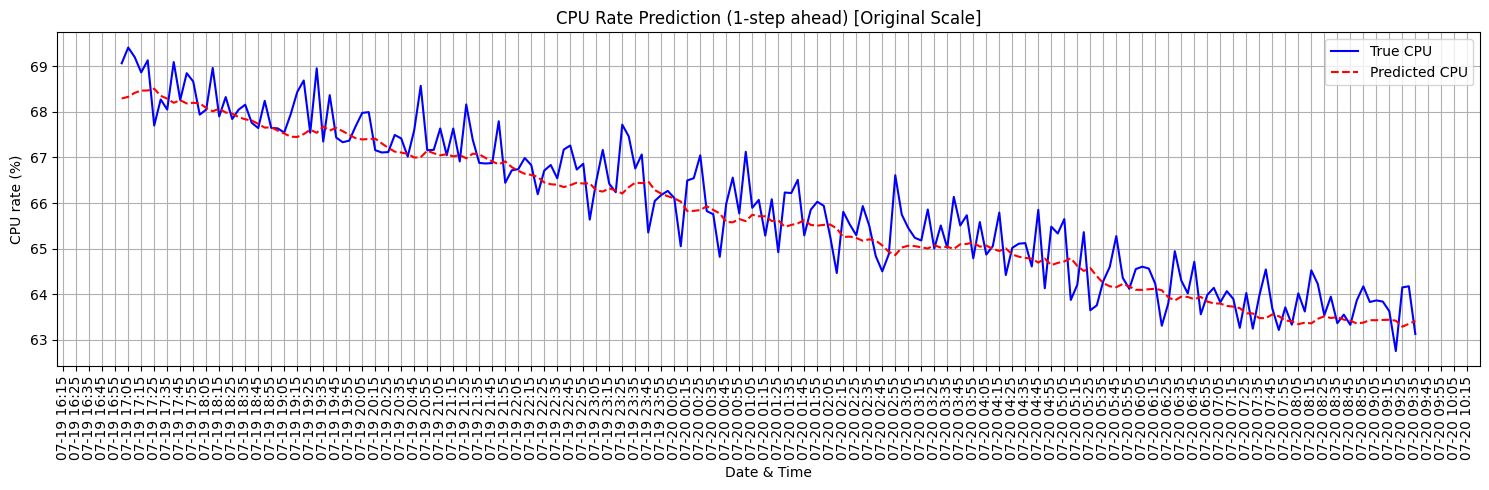

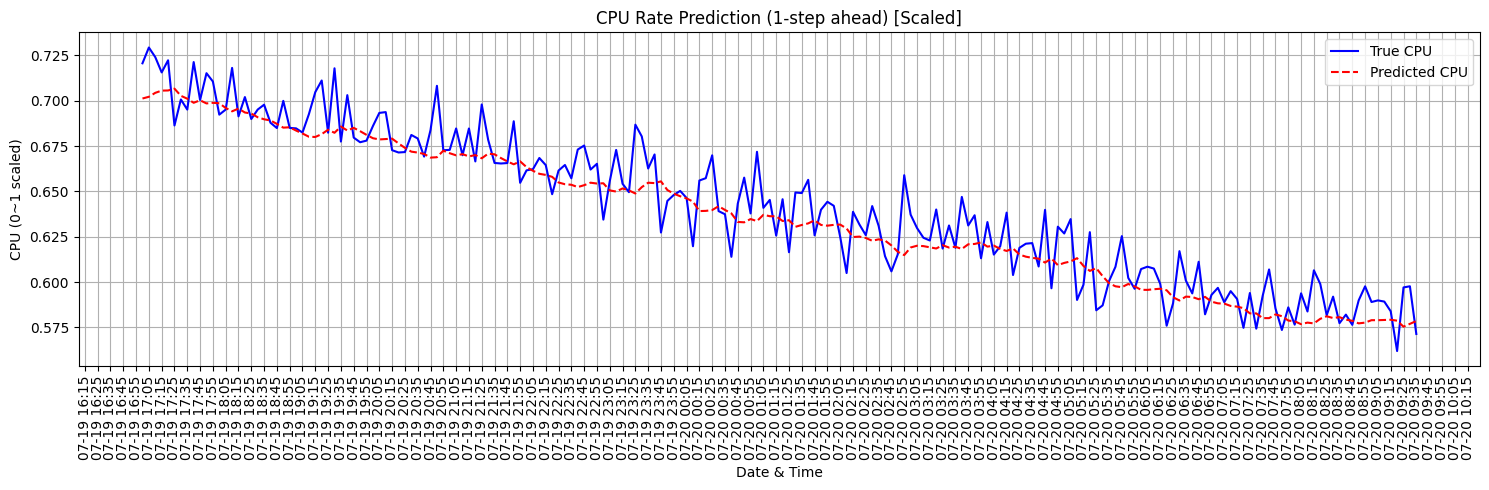

In [ ]:
import matplotlib.dates as mdates

test_start_idx = len(x_train) + lookback
test_time_index = df.index[test_start_idx : test_start_idx + len(y_test)]

y_test_inv_series = pd.Series(y_test_inv.flatten(), index=test_time_index)
y_pred_inv_series = pd.Series(y_pred_inv.flatten(), index=test_time_index)
y_test_series = pd.Series(y_test.flatten(), index=test_time_index)
y_pred_series = pd.Series(y_pred.flatten(), index=test_time_index)

def plot_with_time(x_true, x_pred, ylabel, title):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(x_true, label='True CPU', color='blue')
    ax.plot(x_pred, label='Predicted CPU', color='red', linestyle='--')


    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))   # 10분 간격
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # 월-일 시:분 표시

    # x축 라벨 세로(90도 회전)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

    plt.xlabel('Date & Time')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# plot_with_time(y_test_inv_series[:200], y_pred_inv_series[:200],
#                ylabel='CPU rate (%)',
#                title='CPU Rate Prediction (1-step ahead) [Original Scale]')

# plot_with_time(y_test_series[:200], y_pred_series[:200],
#                ylabel='CPU (0~1 scaled)',
#                title='CPU Rate Prediction (1-step ahead) [Scaled]')

plot_with_time(y_test_inv_series[200:400], y_pred_inv_series[200:400],
               ylabel='CPU rate (%)',
               title='CPU Rate Prediction (1-step ahead) [Original Scale]')

plot_with_time(y_test_series[200:400], y_pred_series[200:400],
               ylabel='CPU (0~1 scaled)',
               title='CPU Rate Prediction (1-step ahead) [Scaled]')

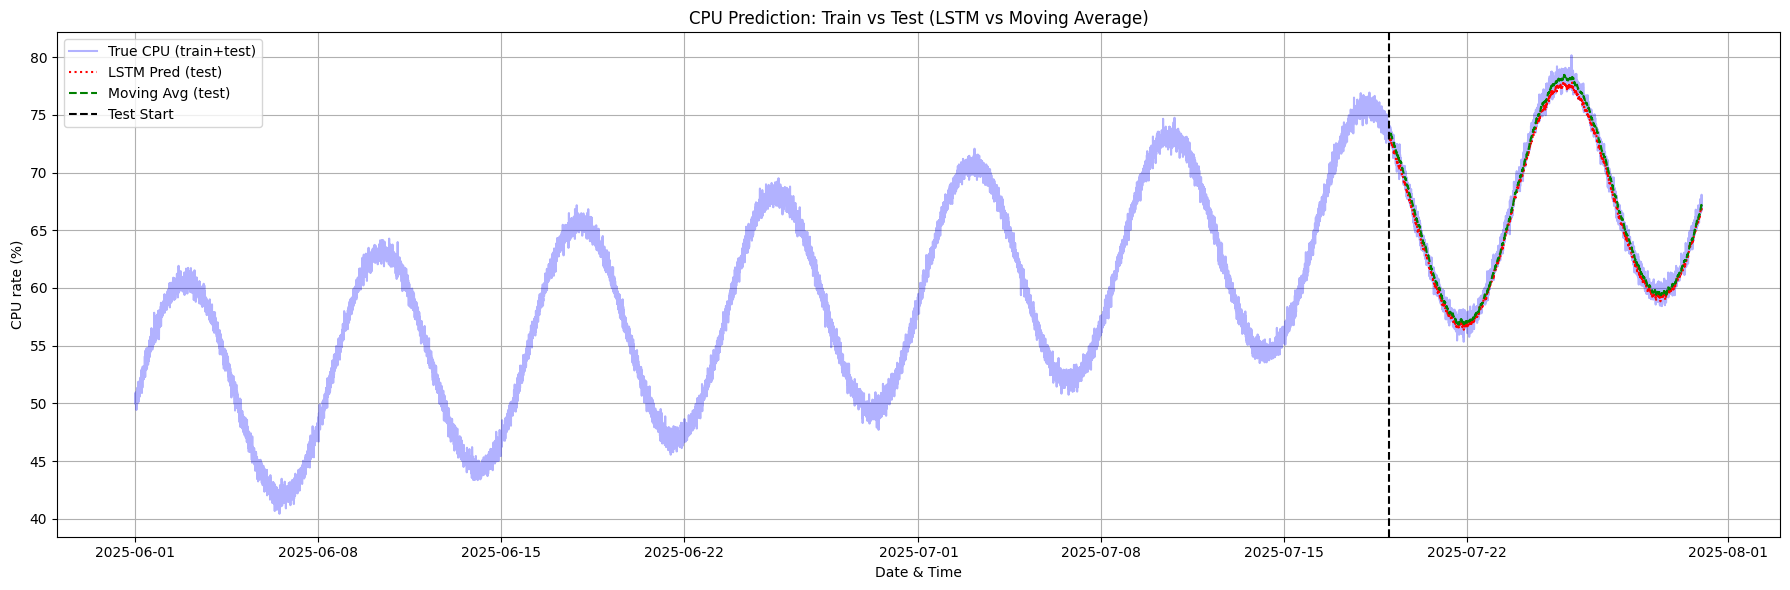

In [ ]:
# training data부분이랑 합해서 test data 함께 plot

k = 20
# 1. 전체 데이터 복원 (CPU%)
df_inv = scaler.inverse_transform(df[['CPU rate']])
df_inv_series = pd.Series(df_inv.flatten(), index=df.index)  # 전체 timeline

# 2. train/test 구간 인덱스 구하기
train_end_idx = len(x_train) + lookback  # sliding window 때문에 lookback offset
test_start_idx = train_end_idx
test_end_idx = test_start_idx + len(y_test_inv)

# 3. test timeline 가져오기
test_time_index = df.index[test_start_idx : test_end_idx]

# 4. moving average & LSTM 예측 시리즈 (datetime 인덱스 적용)
moving_avg_pred_series = pd.Series(moving_avg_pred_inv.flatten(), index=test_time_index[k:])  # k-step 이후
y_pred_inv_series = pd.Series(y_pred_inv.flatten(), index=test_time_index)
y_test_inv_series = pd.Series(y_test_inv.flatten(), index=test_time_index)
y_test_inv_moving_avg_series = pd.Series(y_test_inv_moving_avg.flatten(), index=test_time_index[k:])

# 5. 플롯 (전체 timeline + 테스트 결과 overlay)
plt.figure(figsize=(18,6))

# 전체 timeline의 실제 CPU 값
plt.plot(df_inv_series, label="True CPU (train+test)", color='blue', alpha = 0.3)

# test 구간에서만 LSTM & moving avg 표시
plt.plot(y_pred_inv_series, label="LSTM Pred (test)", color='red', linestyle=':')
plt.plot(moving_avg_pred_series, label="Moving Avg (test)", color='green', linestyle='--')

plt.axvline(x=df.index[test_start_idx], color='black', linestyle='--', label="Test Start")  # test 시작선 표시

plt.title("CPU Prediction: Train vs Test (LSTM vs Moving Average)")
plt.xlabel("Date & Time")
plt.ylabel("CPU rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



 1. result for moving average
MAE : 0.45%
RMSE: 0.56%
MAPE: 0.68%

 2. result for LSTM
MAE : 0.55%
RMSE: 0.68%
MAPE: 0.82%


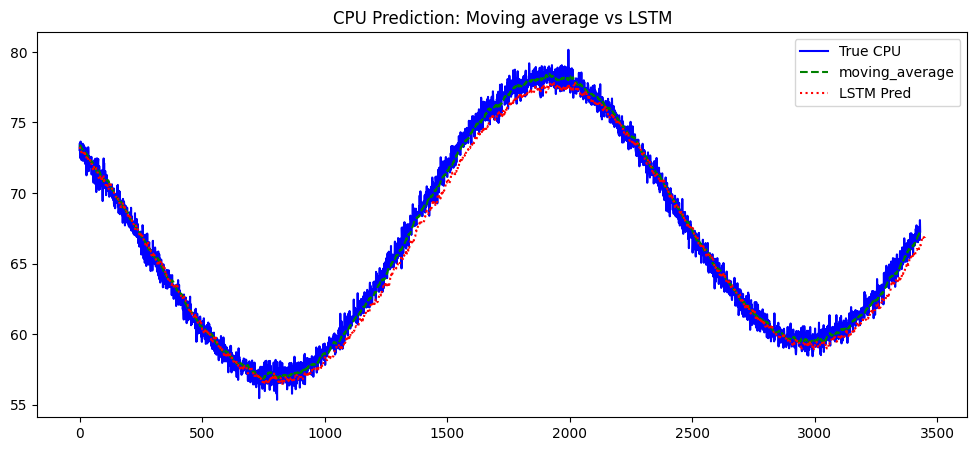

In [ ]:
# compare with moving average
k = 20  # 최근 20개 step 평균으로 예측
moving_avg_pred = []

for i in range(k, len(y_test)):
    moving_avg_pred.append(np.mean(y_test[i-k:i]))  # 최근 k개 평균
moving_avg_pred = np.array(moving_avg_pred).reshape(-1, 1) # 1열로 정렬

# (CPU % 단위)
moving_avg_pred_inv = scaler.inverse_transform(moving_avg_pred)

# true value
y_test_inv_moving_avg = y_test_inv[k:]

# result for mov_avg
mov_avg_mae = mean_absolute_error(y_test_inv_moving_avg, moving_avg_pred_inv)
mov_avg_rmse = np.sqrt(mean_squared_error(y_test_inv_moving_avg, moving_avg_pred_inv))
mov_avg_mape = np.mean(np.abs((y_test_inv_moving_avg - moving_avg_pred_inv) / y_test_inv_moving_avg)) * 100

# result for LSTM
LSTM_mae = mean_absolute_error(y_test_inv, y_pred_inv)
LSTM_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
LSTM_mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print("\n 1. result for moving average")
print(f"MAE : {mov_avg_mae:.2f}%")
print(f"RMSE: {mov_avg_rmse:.2f}%")
print(f"MAPE: {mov_avg_mape:.2f}%")

print("\n 2. result for LSTM")
print(f"MAE : {LSTM_mae:.2f}%")
print(f"RMSE: {LSTM_rmse:.2f}%")
print(f"MAPE: {LSTM_mape:.2f}%")

# compare LSTM with moving_avg
plt.figure(figsize=(12,5))
plt.plot(y_test_inv_moving_avg, label="True CPU", color='blue')
plt.plot(moving_avg_pred_inv, label="moving_average", color='green', linestyle='--')
plt.plot(y_pred_inv, label="LSTM Pred", color='red', linestyle=':')
plt.legend()
plt.title("CPU Prediction: Moving average vs LSTM")
plt.show()


## 2. A Resource Utilization Prediction Model for Cloud Data Centers Using Evolutionary Algorithms and Machine Learning Techniques**

GA: 로컬 최소 탈출 → 더 다양한 후보 탐색

Particle Swarm Optimization (PSO): 빠른 수렴
Adam 대신 GA-PSO로 가중치 진화 최적화

FLNN(Functional Link Neural Network): 입력 데이터에 대해 비선형 함수를 적용하여 새로운 feature 생성함으로써 비선형 문제를 해결

FLNN으로 예측을 하고 예측할때쓰는 가중치를 GA-PSO로 결정하는 구조!!

결과: Adam으로 학습한 CNN-LSTM보다 MAE 20~30% 감소 (논문 기준)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# make dataset
np.random.seed(42)
days = 30
points_per_day = 24 * 12
total_points = days * points_per_day

time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T') # T : 분(minutes) 의미

cpu = 50 + 30*np.sin(np.linspace(0, 10, total_points)) + np.random.normal(0, 5, total_points) # 평균 0, 표준편차 5

df = pd.DataFrame({'timestamp': time_index, 'cpu': cpu})
df.set_index('timestamp', inplace=True) # timestamp를 dataframe의 새로운 인덱스로 (인덱스 자체를 시간 값을 바꿈)

# normalization
scaler = MinMaxScaler()
scaled_cpu = scaler.fit_transform(df[['cpu']].values)

# 3. make sequence for estimating future data (과거 20개 → 미래 5개 예측)
def create_sequences(dataset, past_steps=20, future_steps=5):
    X, y = [], []
    for i in range(len(dataset)-past_steps-future_steps):
        X.append(dataset[i:i+past_steps])
        y.append(dataset[i+past_steps:i+past_steps+future_steps])
    return np.array(X), np.array(y)

past_steps = 20
future_steps = 5
X_seq, y_seq = create_sequences(scaled_cpu, past_steps, future_steps)

# 8:2 학습/테스트 분리
train_size = int(len(X_seq)*0.8)
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_test_seq = y_seq[:train_size], y_seq[train_size:]

print(f"[CNN-LSTM] input shape: {X_train_seq.shape}, output shape: {y_train_seq.shape}")

# =======================================================
# 4. CNN-LSTM 모델
# =======================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                 input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, activation='relu'))
model.add(Dense(future_steps))
model.compile(optimizer='adam', loss='mse')

# 학습
model.fit(X_train_seq, y_train_seq.reshape((y_train_seq.shape[0], -1)),
          epochs=10, batch_size=16, verbose=1)

# 예측
pred_seq = model.predict(X_test_seq)
pred_seq = pred_seq.reshape(-1, future_steps)
y_true_seq = y_test_seq.reshape(-1, future_steps)

# CNN-LSTM MSE
mse_cnnlstm = mean_squared_error(y_true_seq.flatten(), pred_seq.flatten())
print("CNN-LSTM MSE:", mse_cnnlstm)



In [ ]:
# 5. GA-PSO + FLNN 방식
# GA전역탐색 (다양한 가중치 모음) -> PSO로 지역 최적화 (빠르게 가중치로 수렴) -> 최적 가중치 선택

# 비선형 확장 함수 정의
def functional_expansion(X):
    return np.hstack([X, X**2, np.sin(X), np.cos(X)])

def create_flnn_data(dataset, past_steps=20):
    X, y = [], []
    for i in range(len(dataset)-past_steps-1):
        raw = dataset[i:i+past_steps].flatten()
        expanded = functional_expansion(raw)         # 비선형 확장
        X.append(expanded)
        y.append(dataset[i+past_steps])              # 미래 1step
    return np.array(X), np.array(y)


X_flnn, y_flnn = create_flnn_data(scaled_cpu, past_steps=20)
train_size_flnn = int(len(X_flnn)*0.8) # 데이터셋의 총 길이의 80%로 학습 데이터 크기 정함.
X_train_flnn, X_test_flnn = X_flnn[:train_size_flnn], X_flnn[train_size_flnn:]
y_train_flnn, y_test_flnn = y_flnn[:train_size_flnn], y_flnn[train_size_flnn:]

# FLNN Forward (Functional Link Neural Network)
def flnn_forward(X, weights):
    w = weights[:-1]
    return np.dot(X, w)

# 예상값 MAE, 평균 절대 오차 구하는 함수
def fitness_function(weights, X, y):
    y_pred = flnn_forward(X, weights)
    return np.mean(np.abs(y - y_pred))

# GA를 구하기 위한 개체군을 생성
def init_population(pop_size, weight_dim):
    return np.random.uniform(-1, 1, (pop_size, weight_dim))

# GA+PSO 최적화
def ga_pso_optimize(X, y, pop_size=20, max_gen=50, w=0.5, c1=1.5, c2=1.5):
    dim = X.shape[1] +1 # offset 추가로 dim +1
    population = init_population(pop_size, dim)
    velocity = np.zeros_like(population)

    # 초기 fitness
    fitness = np.array([fitness_function(w, X, y) for w in population])
    pbest = population.copy()
    pbest_fitness = fitness.copy()
    gbest = population[np.argmin(fitness)]

    for gen in range(max_gen):
        # GA: crossover + mutation
        idx = np.random.choice(pop_size, pop_size, replace=True)
        crossover_pop = (population + population[idx]) / 2  # 간단 평균 cross-over
        mutation = np.random.uniform(-0.1,0.1,crossover_pop.shape)
        population = crossover_pop + mutation

        # PSO 업데이트
        for i in range(pop_size):
            velocity[i] = (w*velocity[i]
                           + c1*np.random.rand()*(pbest[i]-population[i])
                           + c2*np.random.rand()*(gbest-population[i]))
            population[i] += velocity[i]

        # fitness 업데이트
        fitness = np.array([fitness_function(w, X, y) for w in population])

        # pbest/gbest 업데이트
        for i in range(pop_size):
            if fitness[i] < pbest_fitness[i]:
                pbest[i] = population[i].copy()
                pbest_fitness[i] = fitness[i]
        gbest = population[np.argmin(fitness)]

    return gbest


# GA-PSO로 최적 가중치 찾기
best_weights = ga_pso_optimize(X_train_flnn, y_train_flnn, pop_size=30, max_gen=100)

# 찾은 가중치를 적용해서 FLNN 예측
y_pred_flnn = flnn_forward(X_test_flnn, best_weights)
mse_flnn = mean_squared_error(y_test_flnn, y_pred_flnn)
print("GA-PSO FLNN MSE:", mse_flnn)


print("\n=== 최종 비교 ===")
print(f"CNN-LSTM MSE   : {mse_cnnlstm:.6f}")
print(f"GA-PSO FLNN MSE: {mse_flnn:.6f}")

# 시각화
plt.figure(figsize=(12,5))
plt.plot(y_test_flnn[:200], label="True CPU (normalized)")
plt.plot(y_pred_flnn[:200], label="FLNN Predicted (normalized)")
plt.legend()
plt.title("GA-PSO FLNN")
plt.show()


In [ ]:
offset = np.mean(y_test_flnn) - np.mean(y_pred_flnn)  # 보정값
print(offset)
y_pred_flnn_corrected = y_pred_flnn + offset

plt.figure(figsize=(12,5))
plt.plot(y_test_flnn, label="True CPU")
plt.plot(y_pred_flnn_corrected, label="FLNN Predicted")
plt.legend()
plt.title("GA-PSO FLNN")
plt.show()

mse_flnn_bias = mean_squared_error(y_test_flnn, y_pred_flnn_corrected)
print(f"GA-PSO FLNN MSE: {mse_flnn_bias:.6f}")



### 3. Diffusion Convolutional Recurrent Neural Network (DCRNN), CPU사용량 예측

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ======================
# 1. 데이터 생성 (결측치 0 유지)
# ======================
timesteps = 500   # 총 500 스텝
num_vms = 10      # VM 개수

np.random.seed(42)
data = np.random.rand(timesteps, num_vms) * 100   # 0~100% CPU 사용률
mask = np.random.choice([0, 1], size=data.shape, p=[0.2, 0.8])  # 20% 결측
data *= mask  # 결측치 = 0

# 0~1 스케일링 (논문은 MinMax)
data = data / 100.0

# ======================
# 2. 시퀀스 데이터셋 생성
# ======================
def make_seq(data, lookback=12):
    X, Y = [], []
    for i in range(len(data) - lookback - 1):
        X.append(data[i:i+lookback])   # 과거 12스텝
        Y.append(data[i+lookback])     # 다음 1스텝 예측
    return np.array(X), np.array(Y)

lookback = 12
X_np, Y_np = make_seq(data, lookback)  # numpy [samples, steps, nodes]

# numpy → torch + 마지막 차원 추가
X_torch = torch.tensor(X_np, dtype=torch.float32).unsqueeze(-1)  # [samples, steps, nodes, 1]
Y_torch = torch.tensor(Y_np, dtype=torch.float32).unsqueeze(-1)  # [samples, nodes, 1]

# ======================
# 3. 학습/테스트 split (torch 유지)
# ======================
split_idx = int(len(X_torch) * 0.8)
X_train, X_test = torch.split(X_torch, [split_idx, len(X_torch) - split_idx])
Y_train, Y_test = torch.split(Y_torch, [split_idx, len(Y_torch) - split_idx])

print("Train shape:", X_train.shape, Y_train.shape)
print("Test shape:", X_test.shape, Y_test.shape)

# ======================
# 4. 간단 인접행렬 (논문은 VM간 관계만 사용)
# ======================
num_nodes = num_vms
adj_matrix = torch.ones(num_nodes, num_nodes) / num_nodes  # fully connected 평균그래프

# ======================
# 5. DCRNN 셀 정의
# ======================
class DCRNNCell(nn.Module):
    def __init__(self, num_nodes, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(hidden_dim + 1, hidden_dim)  # 입력1 + 히든 결합

    def forward(self, x, h, adj):
        # Diffusion propagation
        x_diff = adj @ x  # [batch, nodes, 1]
        h_diff = adj @ h  # [batch, nodes, hidden_dim]
        z = torch.cat([x_diff, h_diff], dim=-1)  # concat along feature dim
        return torch.tanh(self.fc(z))

class SimpleDCRNN(nn.Module):
    def __init__(self, num_nodes, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.cell = DCRNNCell(num_nodes, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)  # 출력 1 step

    def forward(self, x, adj):
        # x: [batch, steps, nodes, 1]
        batch, steps, nodes, _ = x.shape
        h = torch.zeros(batch, nodes, self.hidden_dim)  # 초기 hidden
        for t in range(steps):  # 과거 step 순회
            h = self.cell(x[:, t], h, adj)
        return self.fc_out(h)  # [batch, nodes, 1]

# ======================
# 6. 모델/학습 세팅
# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleDCRNN(num_nodes=num_vms, hidden_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)
adj_matrix = adj_matrix.to(device)

# ======================
# 7. 학습 루프
# ======================
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train, adj_matrix)
    loss = loss_fn(pred, Y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_test, adj_matrix)
        val_loss = loss_fn(val_pred, Y_test)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss {loss.item():.4f} | Val Loss {val_loss.item():.4f}")

# ======================
# 8. 예측 및 시각화
# ======================
model.eval()
with torch.no_grad():
    pred_final = model(X_test, adj_matrix).cpu().numpy()  # [samples, nodes, 1]
    true_final = Y_test.cpu().numpy()                     # [samples, nodes, 1]

# VM 하나만 선택해서 시각화
vm_idx = 0
plt.figure(figsize=(10,4))
plt.plot(true_final[:, vm_idx, 0][:200], label="True", marker='o')
plt.plot(pred_final[:, vm_idx, 0][:200], label="Pred", marker='x')
plt.title(f"VM-{vm_idx} CPU Usage Prediction")
plt.xlabel("Time step")
plt.ylabel("CPU usage (0~1 scaled)")
plt.legend()
plt.grid()
plt.show()



### 4. 멀티 입력 변수 (Multivariate) 와 단일 입력 변수 (univariate) 결과 비교

멀티 : 네트워크 사용량은 CPU등과 연관 있음

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler

# np.random.seed(42)

# days = 30
# points_per_day = 24 * 12  # 5분 단위 하루 288포인트
# total_points = days * points_per_day
# time_index = pd.date_range('2025-06-01', periods=total_points, freq='5T')

# # CPU 주기적 패턴 + 노이즈
# cpu = 50 + 30*np.sin(np.linspace(0, 12, total_points)) + np.random.normal(0, 5, total_points)

# # 메모리는 CPU보다 약간 지연 + 0.8배
# mem = 40 + 0.8*cpu + np.random.normal(0, 3, total_points)

# # 네트워크는 CPU보다 약간 더 빠르게 반응
# net = 20 + 0.6*cpu + np.random.normal(0, 4, total_points)

# # 디스크 I/O는 CPU보다 더 지연된 패턴
# disk = 10 + 0.3*np.roll(cpu, 10) + np.random.normal(0, 2, total_points)

# df = pd.DataFrame({
#     'timestamp': time_index,
#     'cpu': cpu,
#     'memory': mem,
#     'network': net,
#     'disk': disk
# }).set_index('timestamp')

# df.head()


### GA-PSO

In [ ]:
from random import randint
from random import random
from math import sqrt
from math import floor

class Particle:
    g_best = [0, 99, 99, 99, 99]
    CROSSOVER_PROB = 0.7
    MUTATION_PROB = 0.1
    W = 0.8
    C1 = 1.5
    C2 = 1.5
    VMAX = 1
    VMIN = -1
    XMAX = 99
    XMIN = 0
    THE_MAP = None
    T = 10

    def __init__(self):
        def starting_pos():
            """ Helper function for initializing the position of
            each particle
            """
            start = []
            for i in range(0, 3):
                start.append(randint(0, 99))
            start = [0] + start + [99]
            return start

        def starting_vel():
            """ Helper function for initializing the velocity of
            each particle
            """
            vel = []
            for i in range(0, 3):
                vel.append(randint(int(Particle.VMIN), int(Particle.VMAX)))
            vel = [0] + vel + [0]
            return vel

        self.v = starting_vel()
        self.x = starting_pos()
        self.p_best = self.x[:]
        self.fit = 0


    def update_velocity(self):
        """Updates the velocity of each dimension in the particle"""
        for i in range(1, len(self.v) - 1):
            vel = Particle.W * self.v[i] + Particle.C1 * random()\
             * (self.p_best[i] - self.x[i]) + Particle.C2 * random() * \
             (Particle.g_best[i] - self.x[i])
            if vel > Particle.VMAX:
                pass
            elif vel < Particle.VMIN:
                pass
            else:
                self.v[i] = vel

    def update_position(self):
        """Updates the position of each dimension in the particle"""
        for i in range(1, len(self.x) - 1):
            new_pos = int(floor((self.x[i] + self.v[i])))
            if new_pos > Particle.XMAX:
                pass
            elif new_pos < Particle.XMIN:
                pass
            else:
                self.x[i] = new_pos


    def mutate(self):
        """Changes some parts of x based on mutation probability"""
        for i in range(1, len(self.x) - 1):  #don't mutate start of goal
            dont_mutate = random()

            if Particle.MUTATION_PROB > dont_mutate:
                self.x[i] = randint(0, 99)


    def crossover(self, other_particle):
        """Takes two particles and exchanges part of the solution at
        a specific point
        """
        crossover_position = randint(1, len(self.x) - 1)
        new1_first_half = self.x[:crossover_position]
        new1_second_half = other_particle.x[crossover_position:]
        new = Particle()
        new.x = new1_first_half
        new.x.extend(new1_second_half)
        new.v = self.v
        new.fit = self.fit
        new.p_best = self.p_best
        return new

    @staticmethod
    def squares_of_line(segment):
        """Returns the squares a line segment cuts"""
        squares = []
        x1 = segment[0] / 10
        y1 = segment[0] % 10
        x2 = segment[1] / 10
        y2 = segment[1] % 10
        y = y1
        x = x1
        dx = x2 - x1
        dy = y2 - y1
        squares.append(x * 10 + y)
        if dy < 0:
            ystep = -1
            dy = -dy
        else:
            ystep = 1
        if dx < 0:
            xstep = -1
            dx = -dx
        else:
            xstep = 1
        ddy = 2 * dy
        ddx = 2 * dx
        if ddx >= ddy:
            errorprev = dx
            error = dx
            for i in range(0, dx):
                x += xstep
                error += ddy
                if error > ddx:
                    y += ystep
                    error -= ddx
                    if error + errorprev < ddx:
                        squares.append(x * 10 + (y - ystep))
                    elif error + errorprev > ddx:
                        squares.append((x - xstep) * 10 + y)
                    else:
                        squares.append(x * 10 + (y - ystep))
                        squares.append((x - xstep) * 10 + y)
                squares.append(x * 10 + y)
                errorprev = error
        else:
            errorprev = dy
            error = dy
            for i in range(0, dy):
                y += ystep
                error += ddx
                if error > ddy:
                    x += xstep
                    error -= ddy
                    if error + errorprev < ddy:
                        squares.append((x - xstep) * 10 + y)
                    elif error + errorprev > ddy:
                        squares.append(x * 10 + (y - ystep))
                    else:
                        squares.append((x -xstep) * 10 + y)
                        squares.append(x * 10 + (y - ystep))
                squares.append(x * 10 + y)
                errorprev = error
        return squares


    @staticmethod
    def obstacles_per_segment(list_of_segments):
        """Returns the number of obstacles a path crosses"""
        obstacles_per_segment = []
        for segment in list_of_segments:
            sqr = Particle.squares_of_line(segment)
            obstacles = 0
            for square in sqr:
                if Particle.THE_MAP[square] ==  1:
                    obstacles += 1
            #don't calculate the same obstacle twice
            if Particle.THE_MAP[segment[0]] == 1:
                obstacles -= 1
            obstacles_per_segment.append(obstacles)
        return obstacles_per_segment

    def calculate_fit(self, path):
        """Calculates the fit of a given path"""
        #break path into line segments
        line_segments = []
        for i in range(0, len(path) - 1):
            line_segments.append(path[i:i+2])

        #calculate euclidian distance of each line segment
        eucl_distances = []
        a_fit = 0
        obstacles = None
        for segment in line_segments:
            px = segment[0] / 10
            py = segment[0] % 10
            qx = segment[1] / 10
            qy = segment[1] % 10
            distance = sqrt((px - qx) ** 2 + (py - qy) ** 2)
            a_fit += distance

        obstacle_factor = []
        obstacles = Particle.obstacles_per_segment(line_segments)
        for nbr_of_obstacles in obstacles:
            if nbr_of_obstacles == 0:
                obstacle_factor.append(0)
            else:
                a = 0
                for i in range(1, nbr_of_obstacles + 1):
                    a += i
                obstacle_factor.append(a * Particle.T)
        for factor in obstacle_factor:
            a_fit += factor
        return a_fit

